# Embedding the Human Disease Network

*(This demo is a part of [Deep Learning for Network Biology](http://snap.stanford.edu/deepnetbio-ismb/) tutorial.)*

Human disease network is a network, in which nodes represent diseases and two diseases are connected to each other if they share at least one gene in which mutations are associated with both diseases.

The network is described in Goh et al., [The Human Disease Network](http://www.pnas.org/content/104/21/8685), PNAS 2007.

The figure below show the human disease network. 

Although the layout of the network was generated independently of any knowledge of disease classes, the resulting network is naturally and visibly clustered according to major disease classes (e.g., bone, cancer, cardiovascular, skeletal, or metabolic diseases; each disease class is represented by a different color). The size of a node is proportional to the number of genes participating in the corresponding disease.

<center>
<img src="diseasome.png" alt="Human disease network" style="width: 700px;"/>
</center>

## This Example

In this example, we take the human disease network and use [node2vec method](http://snap.stanford.edu/deepnetbio-ismb/) to learn an embedding for every node in the network. Node2vec is an unsupervised method and thus it only needs the network's edgelist as the input.

In [1]:
%matplotlib inline

import csv

from matplotlib import pyplot as plt
from sklearn import manifold
import pandas as pd
import numpy as np

**Step 1:** We start by cloning the Github repository with node2vec source code.

In [2]:
!git clone https://github.com/aditya-grover/node2vec.git

fatal: destination path 'node2vec' already exists and is not an empty directory.


**Step 2:** We take [the human disease network](http://snap.stanford.edu/deepnetbio-ismb/ipynb/diseasome.edgelist) and run node2vec algorithm. The algorithm has several optional parameters, such as the dimensionality of embeddings (i.e., 32), the number of random walks simulated from every node in the network (i.e., 20), and the number of epochs in stochastic gradient descent.

The learned embeddings are saved to a file named `diseasome.emb.`

In [3]:
!python node2vec/src/main.py --input diseasome.edgelist --output diseasome.emb --dimensions 32 --num-walks 20 --iter 10

Walk iteration:
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


**Step 3:** We load the learned embeddings into memory. We also read a [metafile with information about disease names and disease classes](http://snap.stanford.edu/deepnetbio-ismb/ipynb/disease.labels). We will use this information to investigate the embeddings.

In [4]:
node2emb = {}
with open('diseasome.emb') as fin:
    fin.readline()
    for line in fin:
        node_emb = line.strip().split()
        node2emb[node_emb[0]] = map(float, node_emb[1:])

nodes, embs = zip(*node2emb.items())
embs = np.array(embs)

In [5]:
node2name_label = {}
with open('disease.labels') as fin:
    fin.readline()
    csvreader = csv.reader(fin)
    for line in csvreader:
        nid, name, label = line
        node2name_label[nid] = name, label

labels = [node2name_label[nid][1] for nid in nodes]
all_labels = list(set(labels))

**Step 4:** We use [t-SNE algorithm](http://www.jmlr.org/papers/v9/vandermaaten08a.html) to give each disease a location in a two-dimensional map based on the disease embedding.

In [6]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
proj = tsne.fit_transform(embs)

**Step 5:** Finally, we visualize disease embeddings in a series of scatter plots. In each plot, points represent diseases. Red points indicate diseases that belong to a particular disease class, such as developmental or cancer diseases.

We see that diseases that are close together in a two-dimensional map tend to belong to the same disease class and affect the same organ system in the human body. This means that diseases that have similar network neighborhoods also have similar embeddings, which, in turn, are indicative of disease phenotypes. This observation is interesting, especially because node2vec has learned the embeddings in an unsupervised manner, relying solely on the network structure of the human disease network and without using any supervised information about disease classes.

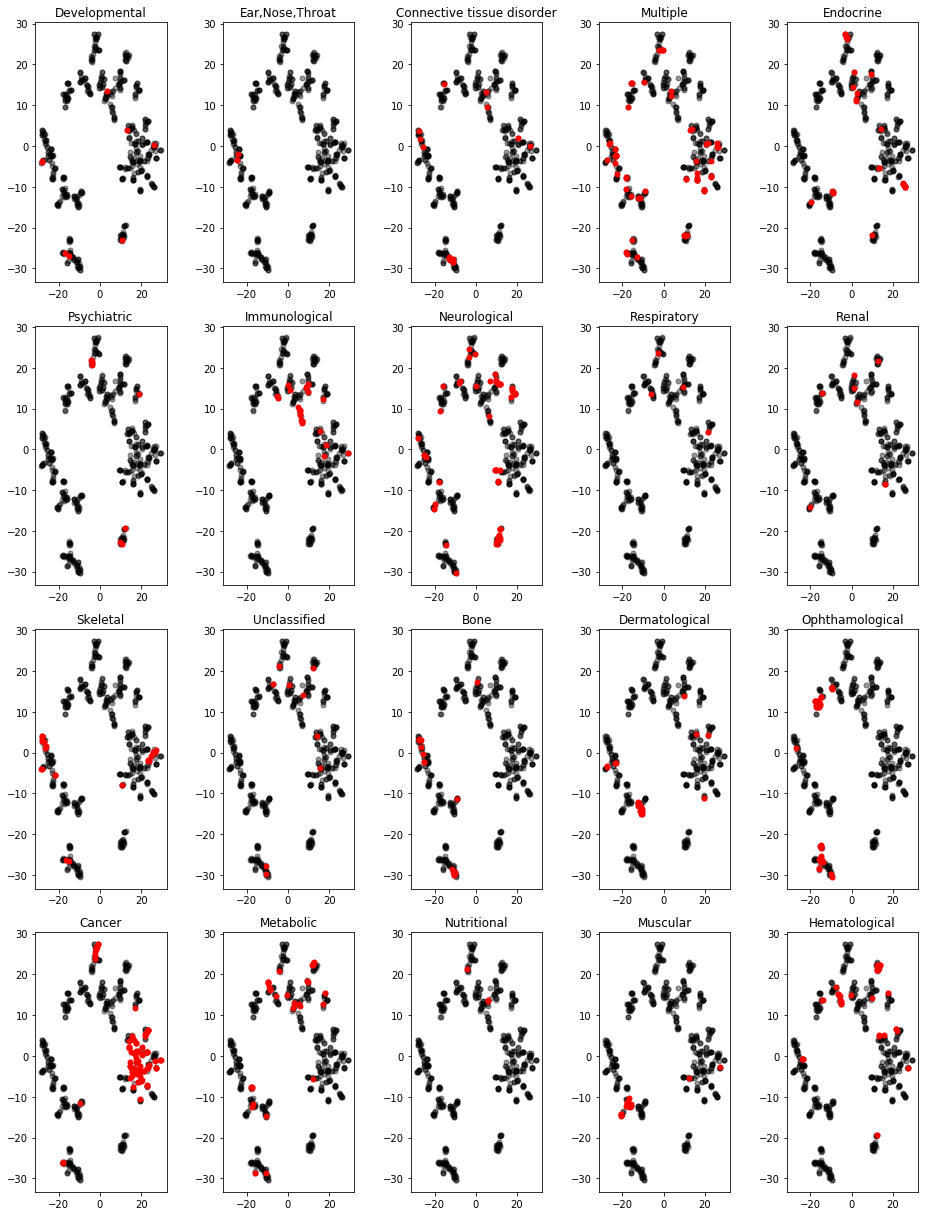

In [7]:
df = pd.DataFrame(dict(x=proj[:, 0], y=proj[:, 1], label=labels))
groups = df.groupby('label')

nr, nc = 4, 5
ii = 0
fig, axes = plt.subplots(nr, nc, figsize=(13, 17))
for r in range(nr):
    for c in range(nc):
        for name, group in groups:
            col, z, a = ('red', 10, 1) if name == all_labels[ii] else ('black', 1, 0.4)
            axes[r, c].plot(group.x, group.y, marker='o', linestyle='', ms=5, color=col, zorder=z, alpha=a)
        axes[r, c].set_title(all_labels[ii])
        ii += 1

plt.tight_layout()